In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
%matplotlib inline

In [124]:
class DataFrame:
    def __init__(self, n, means, cov):
        rot = R.random() # 随机一个旋转矩阵
        self.n = n
        self.k = len(means)
        self.data = rot.apply(np.random.multivariate_normal(means, cov, size = n)) # 旋转
    
    def readFace(self, data): # 读入人脸数据覆盖原先随机的数据
        self.n = len(data)
        self.k = data.shape[1]
        self.data = data
        
    def __str__(self):
        return "n = {0}, k = {1}\nData:\n {2}".format(self.n, self.k, self.data)
    
    def plot(self): #可视化三维数据
        assert self.k == 3, "dim need = 3"
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        ax.scatter(self.data[:, 0], self.data[:, 1], self.data[:, 2], marker = "o", c = '#00DDAA') #color web: https://www.cnblogs.com/xmm2017/p/8441124.html
        return ax, fig
    
    def eval(self, pcaed_data): #峰值信噪比
        minus_data = ((np.array(self.data) - np.array(pcaed_data))** 2) / self.k
        Max_data = np.max(self.data, axis = 1)
        sum_data = minus_data.sum(axis = 1)
        return 20 * np.log10(Max_data / np.square(sum_data))

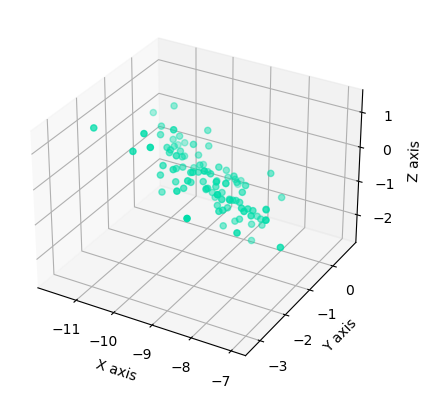

In [125]:
means = [8, -1, 5]
cov = [[1, 0, 0], [0, 1, 0], [0, 0, 0.1]]
Data = DataFrame(100, means, cov)
Data.plot()
plt.show(block = True)
#rot.as_euler('xyz', degrees=True),rot.as_matrix(),rot.as_rotvec()

In [126]:
class PCA:
    def __init__(self, DataFrame, k):
        assert DataFrame.k > k, "DataFrame.dim <= k"
        self.k = k
        self.DataFrame = DataFrame
        self.data, self.mean = self.Means(DataFrame.data) #去中心化的数据
    def Plot_original_data(self): #可视化三维数据（未去中心化）
        return self.DataFrame.plot()
    def Plot_data(self): #可视化三维数据
        assert self.DataFrame.k == 3, "dim need = 3"
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        ax.scatter(self.data[:, 0], self.data[:, 1], self.data[:, 2], marker = "o", c = '#00DDAA') #color web: https://www.cnblogs.com/xmm2017/p/8441124.html
        return ax, fig
    def Means(self, data):  #数据移到中心，均值变0
        Mean = data.sum(axis = 0, keepdims = True) / len(data)
        return data - Mean, Mean
    def Solve(self):
        DataMatrix = np.mat(self.data)
        CovMatrix = DataMatrix.T @ DataMatrix  #协方差矩阵
        eigenValues, eigenVectors = np.linalg.eig(CovMatrix) #计算特征值和特征向量
        eigenSortID = np.argsort(eigenValues)
        eigenVectorSelect = eigenVectors[: ,eigenSortID[: -(self.k + 1): -1]] #选出最大的k个特征值对应的特征向量
        eigenVectorSelect = np.real(eigenVectorSelect) #只取实部
        pcaed_data = np.dot(DataMatrix, eigenVectorSelect) #计算降维后的数据
        return pcaed_data, eigenVectorSelect, np.dot(pcaed_data, eigenVectorSelect.T) + self.mean #返回的第三个值为映射到低维的数据在高维下的坐标

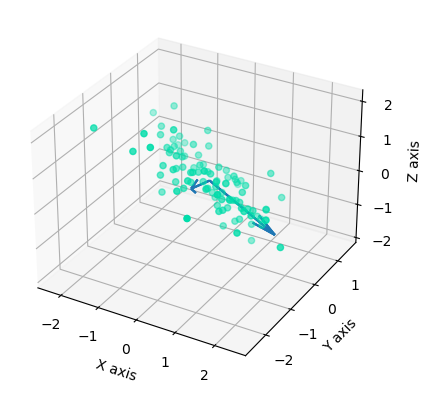

In [127]:
ZERO_POINT = np.array([0, 0, 0])
        
Method = PCA(Data, 2)
solved_data, vec_list, _ = Method.Solve()
ax, fig = Method.Plot_data()
vec_list = vec_list.T.tolist()
for vec in vec_list:
    ax.quiver(ZERO_POINT, ZERO_POINT, ZERO_POINT, ZERO_POINT + 2 * vec[0], ZERO_POINT + 2 * vec[1], ZERO_POINT + 2 * vec[2])
plt.show(block = True)

In [128]:
import os
import cv2

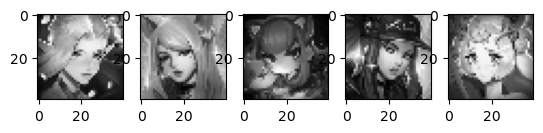

In [129]:
size = (40, 40)

def read_faces(file_path, size): #读入人脸数据
    file_list = os.listdir(file_path)
    data = []
    for file in file_list:
        path = os.path.join(file_path, file)
        with open(path) as f:
            img = cv2.imread(path, 0)
            img = cv2.resize(img, size)
            img_col = img.reshape(img.shape[0] * img.shape[1])
            data.append(img_col)
    return np.array(data)

data_face = read_faces('./face', size)
for i in range(5):
    p = plt.subplot(1, 5, i + 1)
    p.imshow(data_face[i].reshape(size), cmap = 'gray')

In [133]:
Data.readFace(data_face) #将人脸数据覆盖原先的数据
method_face = PCA(Data, 3) 
solved_data, vec_list, remake_data = method_face.Solve()

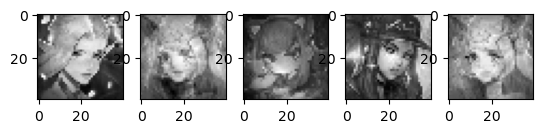

In [134]:
for i in range(5):
    p = plt.subplot(1, 5, i + 1)
    p.imshow(remake_data[i].reshape(size), cmap = 'gray')

In [135]:
Data.eval(remake_data)

array([-18.72870893, -75.19879027, -38.70677121, -38.94642492,
       -67.48286426])